# SVM Classification model on Amazon Fine foods reviews dataset.


 * Our objective here is to build a <b> Support Vector Machine classifier to estimate the polarity of a review as Positive/Negative based on the words used in the review</b>.
 

 * We are given a 500K datset of reviews from Amazon customers regarding the various food products.
 

 * We will be using 5 types of Vectorizations to convert text reviews into vectors and we will conclude towards the best Vectorizer based on several performance metrics.
 
 
 * Instead of Linear SVM from sklearn, we used SGDClassifier with Hinge loss as it is less computationally expensive, but the output will be stochastic in nature.

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import pickle
import seaborn as sns
import matplotlib.gridspec as gs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
#from tqdm import tqdm

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [6]:
con=sqlite3.connect('G:\ML\Data_Sets\Amazon\Cleaned_AmazonDB.sqlite')

In [7]:
data=pd.read_sql_query('''Select * from Reviews''',con)
data.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak watch realli rosi movi incorp...
2,2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [7]:
data.shape

(364171, 13)

## Time based sorting of data:

In [10]:
sorted_data=data.sort_values('Time',axis=0,ascending=True)

In [8]:
sorted_data.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year child sister ...
424,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur star michael keaton...
423,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## Splitting of Test and Train data

In [11]:
train_length=round(0.7*len(data))
print(train_length)
test_length=round(0.3*len(data))
print(test_length)
print((train_length+test_length)==len(data))

254920
109251
True


In [12]:
train=sorted_data.head(train_length)
test=sorted_data.tail(test_length)

## Grid Search CV

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [13]:
def grid_s1(x,list_alpha=[10**-2, 10**-1, 10**0, 10 ,10**2]):
    '''
    Program to return optimal values for Hyper Parameter C for linear SVM. .
    '''
    ts=TimeSeriesSplit(n_splits=3)
    #l=['negative','positive']
    par=[{'alpha': list_alpha}]
    svm=SGDClassifier(penalty='l2',class_weight='balanced',random_state=33)
    grid=GridSearchCV(svm,par,cv=ts.split(x),scoring='f1_micro',verbose=1)
    return grid

In [13]:
def grid_s(x,list_c=[10**-3, 10**-2,10**-1, 10**0, 10 ,10**2,10**2],list_gamma=[10**-2, 10**-2,10**-1, 10**0, 10 ,10**2,10**3]):
    '''
    Program to return optimal values for Hyper Parameter C for RBF SVM.
    '''
    ts=TimeSeriesSplit(n_splits=3)
    l=['negative','positive']
    par=[{'C': list_c,'gamma': list_gamma}]
    svm=SVC(kernel='rbf',random_state=33)
    grid=GridSearchCV(svm,par,cv=ts.split(x),scoring='f1_micro',verbose=1,n_jobs=-1)
    return grid

## Randomized Search CV

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [15]:
def random_s1(x):
    '''
    To tune Hyper paramater using Randomized Search CV for linear SVM
    '''
    ts=TimeSeriesSplit(n_splits=10)
    par={'C': uniform.rvs(loc=0,scale=10**2,size=6)}
    svm=SGDClassifier(penalty='l1',class_weight='balanced')
    rand=RandomizedSearchCV(svm,par,cv=ts.split(x),scoring='accuracy',verbose=1,n_iter=6)
    return rand

In [16]:
def random_s(x):
    '''
    To tune Hyper paramater using Randomized Search CV for RBF SVM
    '''
    ts=TimeSeriesSplit(n_splits=10)
    par={'C': uniform.rvs(loc=10**-2,scale=10**2,size=5),'gamma':uniform.rvs(loc=10**-2,scale=10**2,size=5)}
    svm=SVC(kernel='rbf',random_state=33,class_weight='balanced')
    rand=RandomizedSearchCV(svm,par,cv=ts.split(x),scoring='accuracy',verbose=1,n_iter=5)
    return rand

## CV Plotter:

In [17]:
def plotter(x):
    '''
    To plot CV error with different values of depth.
    '''
    tmp=pd.DataFrame(x.cv_results_)
    plt.figure(figsize=(9,5))
    sns.set_style('darkgrid')
    plt.plot(tmp['param_alpha'],1-tmp['mean_test_score'],'b',label='CV Error')
    plt.plot(tmp['param_alpha'],1-tmp['mean_train_score'],'r',label='Train Error')
    plt.xlabel('Alpha --> ')
    plt.ylabel('CV Error-->')
    plt.title('Variation in CV error of the tree With respect to alpha')
    #plt.grid()
    plt.legend()
    plt.show()

## Feature importance

In [18]:
from wordcloud import WordCloud
def feat_imp(weight,vectorizer):
    '''
    To print top 20 features in a word cloud
    '''
    top=weight.ravel().argsort()[::-1]
    #print(top.shape)
    print('\n Top 20 important features are : \n')
    top_20=''
    for i in range(20):
        #print( np.take(vectorizer.get_feature_names(),top[i]))
        tmp=(np.take(vectorizer.get_feature_names(),top[i]))
        #print(tmp)
        top_20=top_20+tmp+' '  
    wc=WordCloud(width=800,height=700,background_color='white').generate(top_20)
    plt.figure(figsize=(6,6))
    plt.imshow(wc)
    plt.axis('off')

## Multicolinearity check:

In [19]:
from scipy import spatial
def isMultiColinear(weight,new_weight,length):
    '''
    To check Multi colinearity
    '''
    count=0
    d=spatial.distance.euclidean(weight,new_weight)
    print(f'\n The Euclidean distance between weight vectors after perturbation is {d}')
    cos_d=spatial.distance.cosine(weight,new_weight)
    print(f'\n The Cosine distance between weight vectors after perturbation is {cos_d}')
    
    for i in range(0,length-1):  
        x=(abs(weight[:,i]-new_weight[:,i]))/weight[:,i]
        if(x >= 0.05):
            #print(f'\n The feature {i+1} varies by more than 20% after the perturbation ')
            count+=1
    if(count!=0):
        print(f'\n {count} number of features out of {length} are multicollinear as they vary by more than 35% after perturbation')

## Confusion Matrix & Performance Analyser:

In [14]:
def CM(x,y,x1,y1):
    '''
    Function to plot confusion matrix and measure performance of a model
    '''
    CM_Matrix=confusion_matrix(x,y)
    CM_Matrix_train=confusion_matrix(x1,y1)
    print('\n******************************************************************************* \n')
    print(f' Accuracy of train is {accuracy_score(x1,y1)}\n')
    print(f' Accuracy of test is {accuracy_score(x,y)}')
    print('\n******************************************************************************* \n')
    
    #print(f" TNR value is {tn/(tn+fn)}")
    #print(f" FNR value is {fn/(tn+fn)}")
    #print(f" FPR value is {fp/(tp+fp)}")
    #print(f" TPR value is {tp/(tp+fp)}")
    
    
    print('Classification report of train is \n')
    print(classification_report(x1,y1,target_names=['Negative','Positive']))
    print('\n******************************************************************************* \n')
    print('Classification report of test is \n')
    print(classification_report(x,y,target_names=['Negative','Positive']))
    
    print('\n******************************************************************************* \n')
    print('Heat Map of the Confusion matrix is')
    g=gs.GridSpec(1,2)
    a=plt.figure(figsize=(15,5))
    plt.subplot(g[0,0])
    tmp=pd.DataFrame(CM_Matrix)
    tn,fp,fn,tp=CM_Matrix.ravel()
    ann=np.array([['True Negative = '+str(tn),'False Positive = '+str(fp)],['False Negative = '+str(fn),'True Positive = '+str(tp)]])
    sns.heatmap(tmp,annot=ann,fmt='',cmap="YlGnBu")
    plt.title('Confusion Matrix of test')
    
    plt.subplot(g[0,1])
    tmp=pd.DataFrame(CM_Matrix_train)
    tn,fp,fn,tp=CM_Matrix_train.ravel()
    ann=np.array([['True Negative = '+str(tn),'False Positive = '+str(fp)],['False Negative = '+str(fn),'True Positive = '+str(tp)]])
    sns.heatmap(tmp,annot=ann,fmt='',cmap="Greens")
    plt.title('Confusion Matrix of train')
    
    print('\n******************************************************************************* \n')
    
    

# <center> 1.) TF-IDF Vectorization:

In [67]:
tfidf=TfidfVectorizer(dtype='float',min_df=2)
tfidf.fit(train['New'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='float', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=2, ngram_range=(1, 1),
        norm='l2', preprocessor=None, smooth_idf=True, stop_words=None,
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [68]:
tfidf_train= tfidf.transform(train['New'])
tfidf_test= tfidf.transform(test['New'])

In [69]:
tfidf_train.shape

(254920, 28694)

In [70]:
scaler=StandardScaler(with_mean=False)
std_tfidf_train=scaler.fit_transform(tfidf_train)
std_tfidf_test=scaler.transform(tfidf_test)

## Linear SVM

CV-2

In [71]:
b2=grid_s1(std_tfidf_train[0:100000],[0.1,5,10,15,20])

In [72]:
b2.fit(std_tfidf_train[0:100000],train['Score'][0:100000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   22.3s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001B10F1CAEB8>,
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.1, 5, 10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

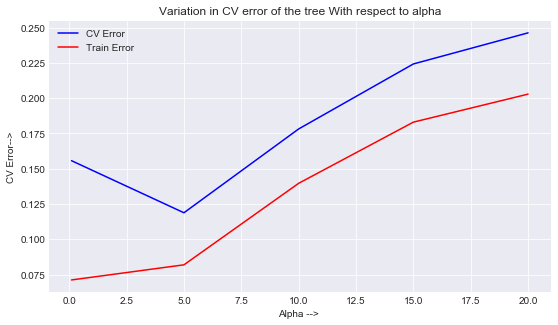

In [73]:
plotter(b2)

Inflection point is at around <b> alpha =5

### Implementation:

In [74]:
svm=SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [75]:
svm.fit(std_tfidf_train,train['Score'])

SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [76]:
pred = svm.predict(std_tfidf_test)
pred1 = svm.predict(std_tfidf_train)

## Performance of Linear SVM on Tf-Idf:


******************************************************************************* 

 Accuracy of train is 0.8813588576808411

 Accuracy of test is 0.855580269288153

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.57      0.88      0.69     38029
   Positive       0.98      0.88      0.93    216891

avg / total       0.91      0.88      0.89    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.56      0.84      0.67     19081
   Positive       0.96      0.86      0.91     90170

avg / total       0.89      0.86      0.87    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

*************************************************

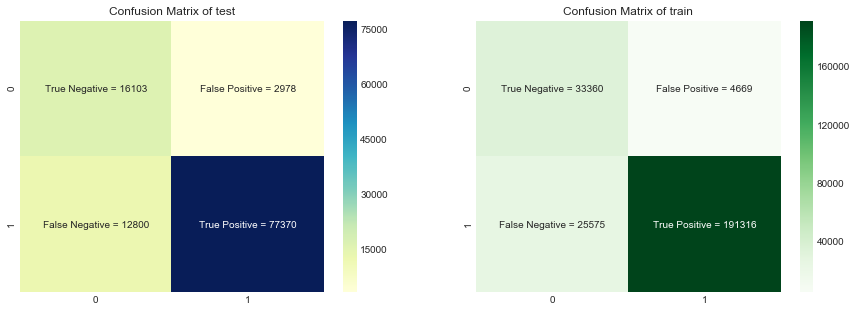

In [78]:
CM(test['Score'],pred,train['Score'],pred1)

### Feature importance:


 The Euclidean distance between weight vectors after perturbation is 0.0023500238217328755

 The Cosine distance between weight vectors after perturbation is 3.75828509951992e-05

 Top 20 important features are : 



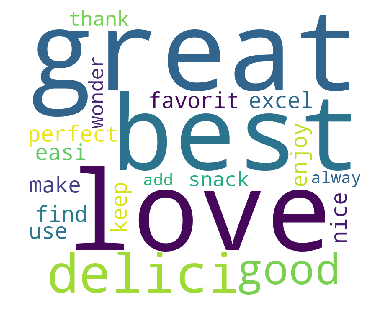

In [79]:
weights= svm.coef_
new=tfidf_train
tfidf_train.data+=0.001
std=scaler.transform(tfidf_train)
svm.fit(std,train['Score'])
tfidf_train=new
perturbated_weight=svm.coef_
length=len(perturbated_weight)
isMultiColinear(weights,perturbated_weight,length)
feat_imp(weights,tfidf)

### RBF Kernel SVM :

In [36]:
t_grid=grid_s(std_tfidf_train[:40000])

In [37]:
t_grid.fit(std_tfidf_train[:40000],train['Score'][:40000])

Fitting 2 folds for each of 49 candidates, totalling 98 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed: 42.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fc5c2921e60>,
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=33,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=1)

In [38]:
t_grid.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=33, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
t_grid.best_score_

0.8436394434187682

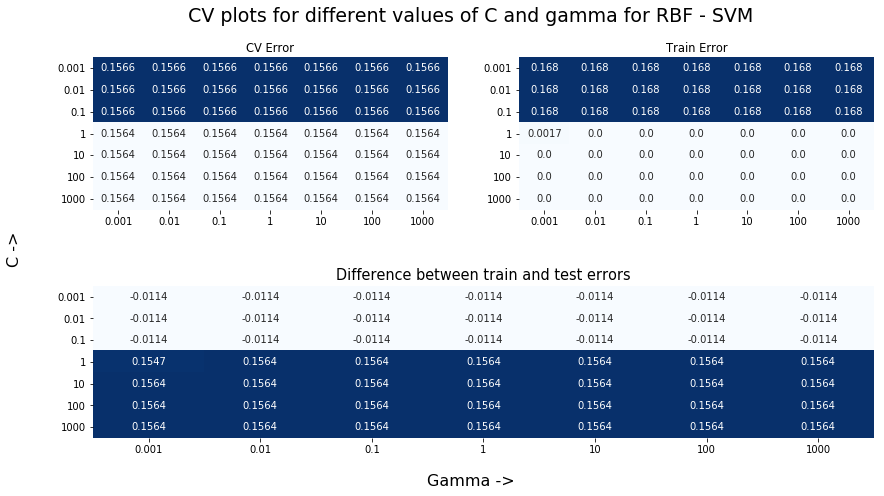

In [42]:
error_plots_RBF(t_grid)

From the above plot, we can see that TBF SVM easily tend to overfit as for c>1 except for gamma=0.01, training error seem to be zero which means that the model is overfit. We will select our hyperparameter as our best estimator,<b> C=1,Gamma=0.01

### Implementation:

In [0]:
svm=SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=33, shrinking=True,
  tol=0.001, verbose=False)


In [16]:
svm.fit(std_tfidf_train[:100000],train['Score'][:100000])

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=33, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
pred=svm.predict(std_tfidf_test[:50000])
pred1=svm.predict(std_tfidf_train[:100000])

## Performace of SVM-RBF model with TF-IDF:


******************************************************************************* 

 Accuracy of train is 0.99968

 Accuracy of test is 0.82584

******************************************************************************* 

Classification report of train is 

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     12271
    Positive       1.00      1.00      1.00     87729

   micro avg       1.00      1.00      1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000


******************************************************************************* 

Classification report of test is 

              precision    recall  f1-score   support

    Negative       0.81      0.03      0.06      8907
    Positive       0.83      1.00      0.90     41093

   micro avg       0.83      0.83      0.83     50000
   macro avg       0.82      0.51      0.48     50000
weighted avg       0.

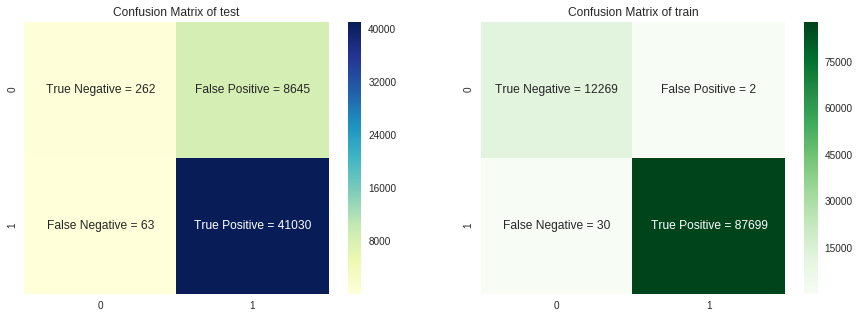

In [20]:
CM(test['Score'][:50000],pred,train['Score'][:100000],pred1)

Thus the model seem to perform very poor with even the best estimator that we obtained using CV. This is because RBF SVM Easily tend to overfit which is clearly evident from the above confusion matrix of train data.

# <center> 2.) Bag Of Words Vectorization:

In [24]:
BOW=CountVectorizer(dtype='float')
BOW.fit(train['New'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='float', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=1, ngram_range=(1, 1),
        preprocessor=None, stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [25]:
BOW_train= BOW.transform(train['New'])
BOW_test=BOW.transform(test['New'])

In [26]:
BOW_train.shape

(254920, 55207)

In [27]:
scaler=StandardScaler(with_mean=False)
std_BOW_train=scaler.fit_transform(BOW_train)
std_BOW_test=scaler.transform(BOW_test)

## Linear SVM

CV-1

In [34]:
b1=grid_s1(std_BOW_train[0:100000])

In [35]:
b1.fit(std_BOW_train[0:100000],train['Score'][0:100000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   22.3s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001B13CB6CF10>,
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [36]:
b1.best_estimator_

SGDClassifier(alpha=1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [37]:
b1.best_score_

0.89028

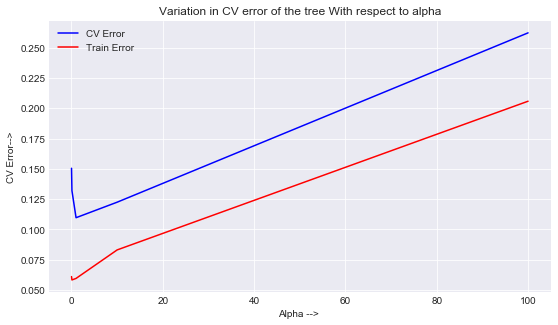

In [38]:
plotter(b1)

Here there is a sudden change in error for alpha in range of 0 - 20 and so lets analyse it further to get an exact elbow point.

CV-2

In [39]:
b2=grid_s1(std_BOW_train[0:100000],[0.1,5,10,15,20])

In [40]:
b2.fit(std_BOW_train[0:100000],train['Score'][0:100000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   22.9s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001B13CB6CD00>,
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.1, 5, 10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

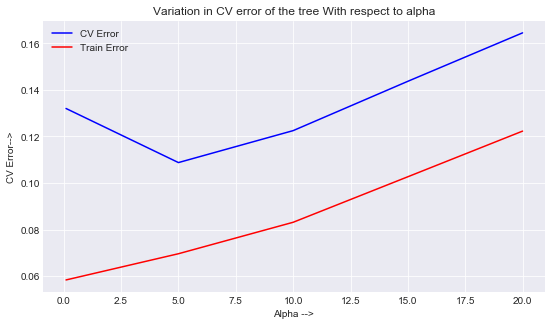

In [41]:
plotter(b2)

So the inflection point is at around <b> alpha =5

### Implementation:

In [42]:
svm=SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [43]:
svm.fit(std_BOW_train,train['Score'])

SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [46]:
pred = svm.predict(std_BOW_test)
pred1=svm.predict(std_BOW_train)

## Performance of Linear SVM on BOW_Unigram


******************************************************************************* 

 Accuracy of train is 0.8951121920602542

 Accuracy of test is 0.8671865703746419

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.60      0.89      0.72     38029
   Positive       0.98      0.90      0.94    216891

avg / total       0.92      0.90      0.90    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.58      0.85      0.69     19081
   Positive       0.96      0.87      0.92     90170

avg / total       0.90      0.87      0.88    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

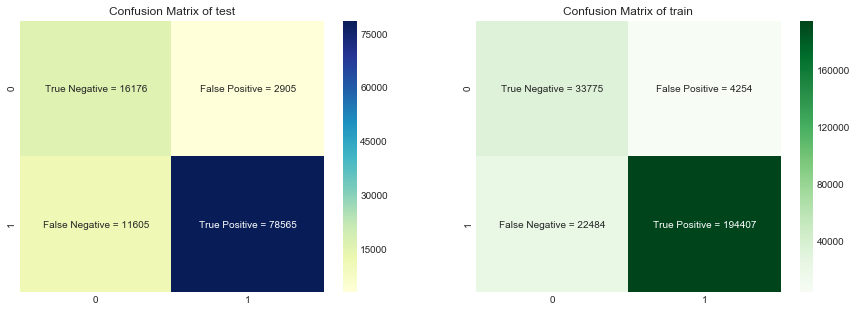

In [51]:
CM(test['Score'],pred,train['Score'],pred1)

### Feature importance:

In [52]:
weights= svm.coef_
new=BOW_train
BOW_train.data+=0.001
std=scaler.transform(BOW_train)
svm.fit(std,train['Score'])
BOW_train=new
perturbated_weight=svm.coef_
length=len(perturbated_weight)
isMultiColinear(weights,perturbated_weight,length)


 The Euclidean distance between weight vectors after perturbation is 0.0016383200787827591

 The Cosine distance between weight vectors after perturbation is 2.258378588493315e-05


In [155]:
weights.shape

(1, 55207)


 Top 20 important features are : 



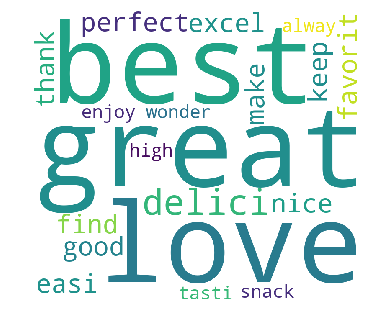

In [24]:
feat_imp(weights,BOW)

# <center>3.) BOW - Bi-gram Vectorization:

In [55]:
BOW1=CountVectorizer(ngram_range=(1,2),dtype='float',min_df=3)
BOW1.fit(train['New'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='float', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=3, ngram_range=(1, 2),
        preprocessor=None, stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [56]:
BOW1_train= BOW1.transform(train['New'])
BOW1_test=BOW1.transform(test['New'])

In [58]:
BOW1_train.shape

(254920, 489523)

In [57]:
scaler=StandardScaler(with_mean=False)
std_BOW1_train=scaler.fit_transform(BOW1_train)
std_BOW1_test=scaler.transform(BOW1_test)

## Linear SVM

CV-2

In [59]:
b2=grid_s1(std_BOW1_train[0:100000],[0.1,5,10,15,20])

In [60]:
b2.fit(std_BOW1_train[0:100000],train['Score'][0:100000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   27.2s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001B10F1CA570>,
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.1, 5, 10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

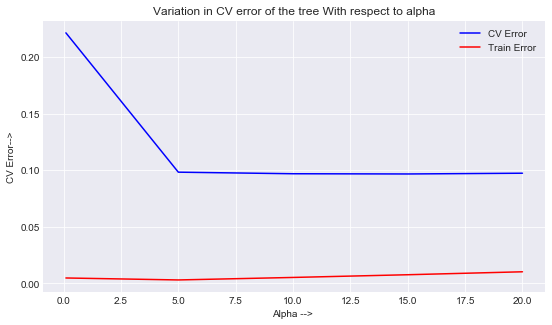

In [61]:
plotter(b2)

Inflection point is at around <b> alpha =5

### Implementation:

In [62]:
svm=SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [63]:
svm.fit(std_BOW1_train,train['Score'])

SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [64]:
pred = svm.predict(std_BOW1_test)
pred1 = svm.predict(std_BOW1_train)

## Performance of Linear SVM on BOW_Bigram


******************************************************************************* 

 Accuracy of train is 0.9737407814216225

 Accuracy of test is 0.9133737906289188

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.86      0.99      0.92     38029
   Positive       1.00      0.97      0.98    216891

avg / total       0.98      0.97      0.97    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.73      0.79      0.76     19081
   Positive       0.96      0.94      0.95     90170

avg / total       0.92      0.91      0.91    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

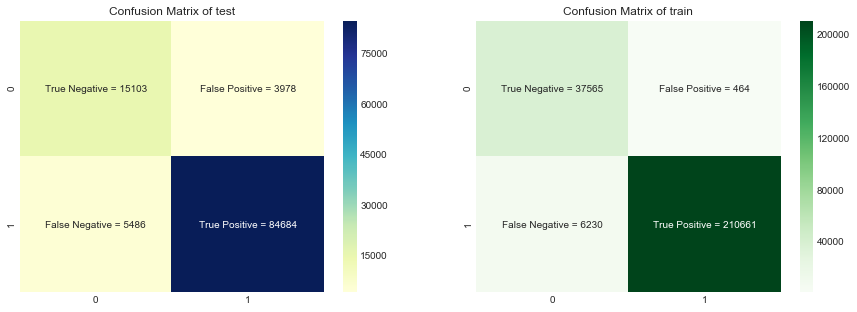

In [65]:
CM(test['Score'],pred,train['Score'],pred1)

### Feature importance:

In [66]:
weights= svm.coef_
new=BOW1_train
BOW1_train.data+=0.001
std=scaler.transform(BOW1_train)
svm.fit(std,train['Score'])
BOW1_train=new
perturbated_weight=svm.coef_
length=len(perturbated_weight)
isMultiColinear(weights,perturbated_weight,length)


 The Euclidean distance between weight vectors after perturbation is 0.013216961667588446

 The Cosine distance between weight vectors after perturbation is 0.0009696282188121907


Top 20 important features are : 



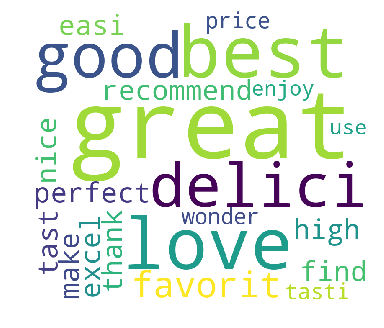

In [47]:
feat_imp(weights,BOW1)

# <center>Building W2V Model:

In [11]:
from gensim.models import Word2Vec

In [12]:
#Creating sentence list

sentence_list=[]
for sentence in train['New']:
    sentence_list.append(sentence.split())

#sentence_list[5]


In [13]:
w2v=Word2Vec(sentence_list,size=200,min_count=1,workers=4)

In [14]:
w2v_list=list(w2v.wv.vocab)

In [26]:
len(w2v_list)

55208

# <center>4.) Average W2V Vectorization:

In [29]:
def avgwv(x):
    '''
    To calculate average word 2 vector model
    '''
    sent_vect=[]
    for sentence in x:
        count=0;
        s_v=np.zeros(200)
        for words in sentence.split():
            if words in w2v_list:
                V=w2v.wv[words]
                count+=1
                s_v+=V
            if (count!=0):
                s_v/=count
        sent_vect.append(s_v)
    return(sent_vect)
                    

In [30]:
train_w2v=avgwv(train['New'])

In [31]:
test_w2v=avgwv(test['New'])

In [15]:
with open(r'G:\ML\Pickles\Avgw2v_200d.pickle','rb') as f:
    train_w2v,test_w2v=pickle.load(f)

In [16]:
scaler=StandardScaler(with_mean=False)
std_train_avgw2v=scaler.fit_transform(train_w2v)
std_test_avgw2v=scaler.transform(test_w2v)

## Linear SVM

CV-2

In [82]:
b2=grid_s1(std_train_avgw2v[0:100000],[0.1,5,10,15,20])

In [83]:
b2.fit(std_train_avgw2v[0:100000],train['Score'][0:100000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   27.6s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001B10F1CABF8>,
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.1, 5, 10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

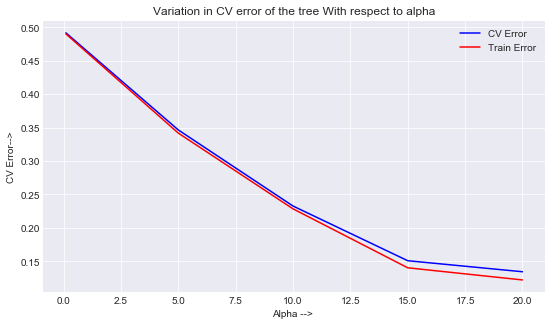

In [84]:
plotter(b2)

inflection point is at around <b> alpha =15

### Implementation:

In [85]:
svm=SGDClassifier(alpha=15, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [86]:
svm.fit(std_train_avgw2v,train['Score'])

SGDClassifier(alpha=15, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [87]:
pred = svm.predict(std_test_avgw2v)
pred1 = svm.predict(std_train_avgw2v)


******************************************************************************* 

 Accuracy of train is 0.8513808253569748

 Accuracy of test is 0.8270404847552882

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.55      0.02      0.04     38029
   Positive       0.85      1.00      0.92    216891

avg / total       0.81      0.85      0.79    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.65      0.02      0.04     19081
   Positive       0.83      1.00      0.90     90170

avg / total       0.80      0.83      0.75    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

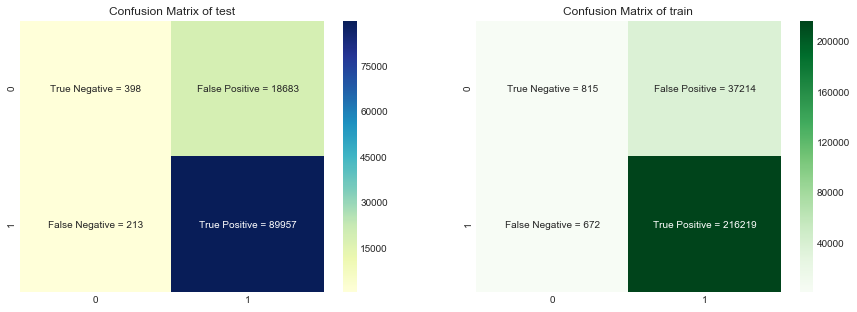

In [88]:
CM(test['Score'],pred,train['Score'],pred1)

As the model seem to be underfitting, we will take value of first inflcection of alpha as 5.

In [89]:
svm=SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [90]:
svm.fit(std_train_avgw2v,train['Score'])

SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [91]:
pred = svm.predict(std_test_avgw2v)
pred1 = svm.predict(std_train_avgw2v)


******************************************************************************* 

 Accuracy of train is 0.8382394476698573

 Accuracy of test is 0.8190039450439813

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.38      0.14      0.20     38029
   Positive       0.86      0.96      0.91    216891

avg / total       0.79      0.84      0.80    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.44      0.14      0.21     19081
   Positive       0.84      0.96      0.90     90170

avg / total       0.77      0.82      0.78    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

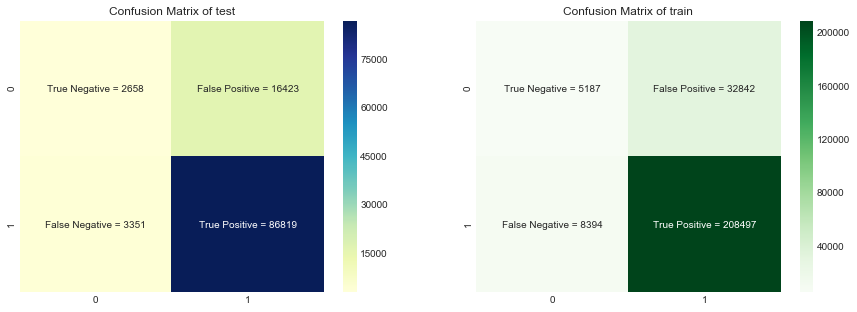

In [92]:
CM(test['Score'],pred,train['Score'],pred1)

Lets decrease alpha further to 3 and see if it improves.

In [39]:
svm=SGDClassifier(alpha=3, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [40]:
svm.fit(std_train_avgw2v,train['Score'])

SGDClassifier(alpha=3, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [41]:
pred = svm.predict(std_test_avgw2v)
pred1 = svm.predict(std_train_avgw2v)


******************************************************************************* 

 Accuracy of train is 0.7860858308488937

 Accuracy of test is 0.7681394220647866

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.29      0.31      0.30     38029
   Positive       0.88      0.87      0.87    216891

avg / total       0.79      0.79      0.79    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.33      0.32      0.32     19081
   Positive       0.86      0.86      0.86     90170

avg / total       0.76      0.77      0.77    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

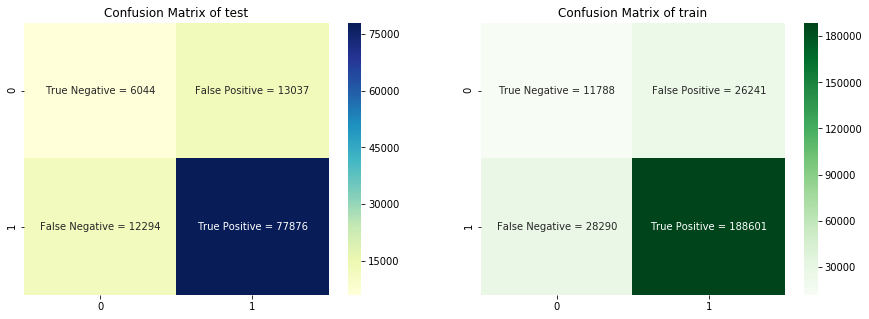

In [42]:
CM(test['Score'],pred,train['Score'],pred1)

This makes positive class suffer more and training is not that good with alpha =3, We can confirm this vectorization is poor for Linear SVM.

## Performance of Linear SVM on Average W2V:


******************************************************************************* 

 Accuracy of train is 0.8382394476698573

 Accuracy of test is 0.8190039450439813

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.38      0.14      0.20     38029
   Positive       0.86      0.96      0.91    216891

avg / total       0.79      0.84      0.80    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.44      0.14      0.21     19081
   Positive       0.84      0.96      0.90     90170

avg / total       0.77      0.82      0.78    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

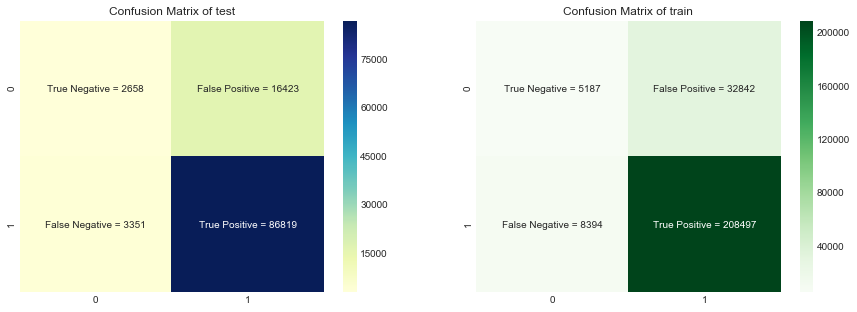

In [92]:
CM(test['Score'],pred,train['Score'],pred1)

# <center>5.) Tf-IDF weighted Word2Vec Vectorization:

In [39]:
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [44]:
features=tfidf.get_feature_names()

def tfidf_w2v(x):
    '''
    To calculate Tf-IDf weighted word2vec for a review
    '''     
    row=0
    sentence_vectors=[]
    for sentences in x:
        weight=0
        s_v=np.zeros(200)
        for words in sentences.split():
            if words in w2v_list:
                try:
                    v=w2v.wv[words]
                    #tfidf_value=y[row,features.index(words)]
                    tfidf_value = dictionary[words]*sentences.count(words)
                    s_v+=(v*tfidf_value)
                    weight+=tfidf_value
                except(KeyError):
                    continue                
            else:
                continue
        if(weight!=0):
            s_v/=weight
        sentence_vectors.append(s_v)
        row+=1
    return sentence_vectors
                
    
    

In [93]:
with open(r'G:\ML\Pickles\tfidfw2v_train_200d.pickle','rb') as f:
    train_tfidf_w2v=pickle.load(f)

In [94]:
with open(r'G:\ML\Pickles\tfidfw2v_test_200d.pickle','rb') as f:
    test_tfidf_w2v=pickle.load(f)

In [95]:
scaler=StandardScaler(with_mean=False)
std_train_tfidfw2v=scaler.fit_transform(train_tfidf_w2v)
std_test_tfidfw2v=scaler.transform(test_tfidf_w2v)

## Linear SVM

CV-1

In [96]:
b2=grid_s1(std_train_tfidfw2v[0:100000],[0.1,5,10,15,20])

In [97]:
b2.fit(std_train_tfidfw2v[0:100000],train['Score'][0:100000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   26.6s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001B13FE5F8E0>,
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.1, 5, 10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

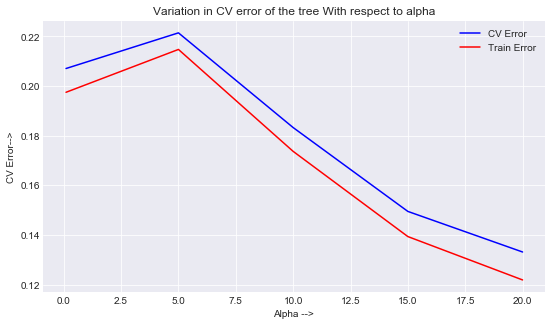

In [98]:
plotter(b2)

From above two CV plots, we cab infer that the inflection point can be observed around <b>alpha = 10.

### Implementation:

In [99]:
svm=SGDClassifier(alpha=15, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [100]:
svm.fit(std_train_tfidfw2v,train['Score'])

SGDClassifier(alpha=15, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [101]:
pred = svm.predict(std_test_tfidfw2v)
pred1 = svm.predict(std_train_tfidfw2v)

## Performance of Linear SVM on Tf-IDF Weighted W2V:


******************************************************************************* 

 Accuracy of train is 0.866330613525812

 Accuracy of test is 0.7782354394925447

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.58      0.40      0.47     38029
   Positive       0.90      0.95      0.92    216891

avg / total       0.85      0.87      0.86    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.21      0.10      0.14     19081
   Positive       0.83      0.92      0.87     90170

avg / total       0.72      0.78      0.74    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

*************************************************

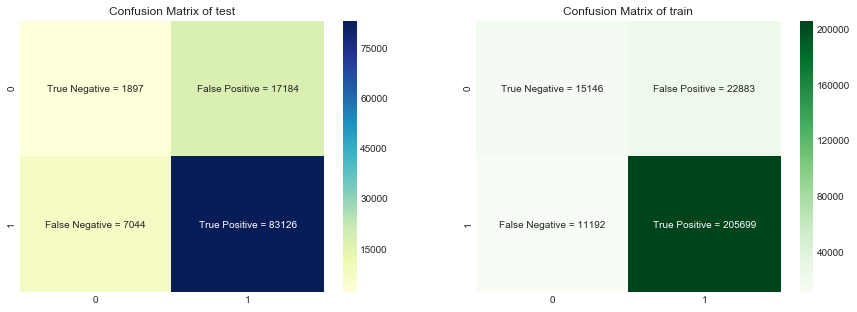

In [102]:
CM(test['Score'],pred,train['Score'],pred1)

From both train and test confusion matrix we can see that the model is underfitting with the data. Lets choose alpha as 5.

In [103]:
svm=SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [104]:
svm.fit(std_train_tfidfw2v,train['Score'])

SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=33, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [105]:
pred = svm.predict(std_test_tfidfw2v)
pred1 = svm.predict(std_train_tfidfw2v)

## Performance of Linear SVM on Tf-IDF Weighted W2V:


******************************************************************************* 

 Accuracy of train is 0.8115879491605209

 Accuracy of test is 0.5855964705128557

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.42      0.74      0.54     38029
   Positive       0.95      0.82      0.88    216891

avg / total       0.87      0.81      0.83    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.20      0.45      0.27     19081
   Positive       0.84      0.62      0.71     90170

avg / total       0.73      0.59      0.63    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

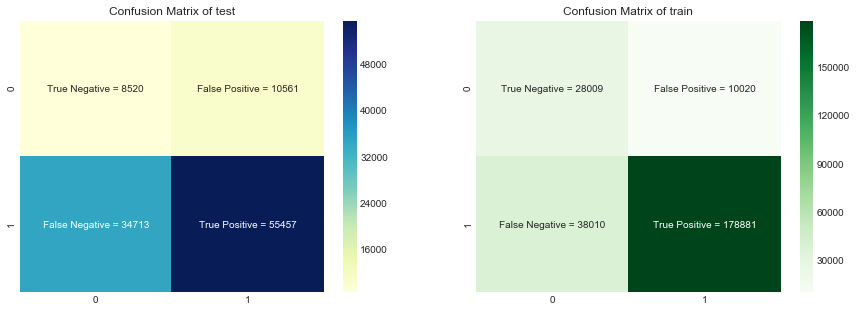

In [106]:
CM(test['Score'],pred,train['Score'],pred1)

Though training is better than the earlier one , still the performance is too bad with test data which tells that this vectorization is not an useful one with Linear SVM.

# Performace comparision between different vectorizations::

In [43]:
tmp=pd.DataFrame(columns=['Type of Vectorization','Kernel type','Alpha','C','Gamma','Train_Accuracy','Test_Accuracy','Train_F1 Score','Test_F1 Score'])
tmp.loc[0]=['Tf-IDF','Linear',5,0,0,0.88,0.85,0.89,0.87]
tmp.loc[1]=['Tf-IDF','RBF',0,1,0.01,0.99,0.82,1,0.75]
tmp.loc[2]=['BOW_Unigram','Linear',5,0,0,0.89,0.86,0.90,0.88]
tmp.loc[3]=['BOW_bigram','Linear',5,0,0,0.97,0.91,0.97,0.91]
tmp.loc[4]=['Avg_W2v','Linear',5,0,0,0.83,0.81,0.80,0.78]
tmp.loc[5]=['Tf-IDF_W2v','Linear',5,0,0,0.81,0.58,0.83,0.63]

In [44]:
tmp

,Type of Vectorization,Kernel type,Alpha,C,Gamma,Train_Accuracy,Test_Accuracy,Train_F1 Score,Test_F1 Score
0,Tf-IDF,Linear,5,0,0,0.88,0.85,0.89,0.87
1,Tf-IDF,RBF,0,1,0.01,0.99,0.82,1.00,0.75
2,BOW_Unigram,Linear,5,0,0,0.89,0.86,0.90,0.88
3,BOW_bigram,Linear,5,0,0,0.97,0.91,0.97,0.91
4,Avg_W2v,Linear,5,0,0,0.83,0.81,0.80,0.78
5,Tf-IDF_W2v,Linear,5,0,0,0.81,0.58,0.83,0.63


# Conclusion from above exercise:

1.) Performance of BOW Bigram seems to be very well with Linear SVM as it has high accuracy of 91.04 and high F1 Score of 0.946.

2.) SVM's perform worse with Word2Vec models compared to the BOW and Tf-IDF ones.

3.) Linear SVM tend to work much better for this data in all types of vectorizations compared to RBF kernel.

4.) RBF SVM takes a lot time to train amongst the linear models so far trained with the same data.

5.) The weight vectors of Linear SVM didnt vary much even after perturbation, Hence Multicollinearity doesn't affect weight vectors.

*****************************************************************************************************************************

 From above exercise, I Suggest that we can use SVM with <i><b> " Linear kernel along with BOW Bigram vectorization "</b></i> to yield a better performing model.

